<a href="https://colab.research.google.com/github/yamazakikeisuke/python_for_journalism-/blob/main/Python_for_journalism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **はじめに**

>オープンデータなどの膨大なデータを独自に分析し、そこから「ニュース」を発見して報じるデータジャーナリズムは、近年、メディアのなかで注目されている新たな調査手法の一つとなっています。

>ただ、データ量が多かったり、複雑な分析をしたりする時にはエクセルなどの表計算ソフトでは不十分で、PythonやRといったプログラム言語を操るスキルが必要になってきます。しかし、技術者ではないジャーナリストにとってプログラムの実行環境の構築やどう分析をし始めるのかなど「一歩踏み出す壁」が低くないのが現状です。

>そこでこのページでは、開発環境の構築が不要なGoogle Colabを使い、Pythonでどうデータを分析して記事に結びつけるかを、実際のコードを示しながらを紹介します。自身のGoogle Colabにコピーしてコードを実行してみたり、自身がもつ他のデータの分析に応用するなどしてご活用下さい。


# **データを読み込む準備**

**①．自身のグーグルドライブと連携する**

分析するデータを読み込むために、まずこのノートブックと自身のグーグルドライブを連携します
（データを直接ダウンロードする場合はこの作業は不要です）

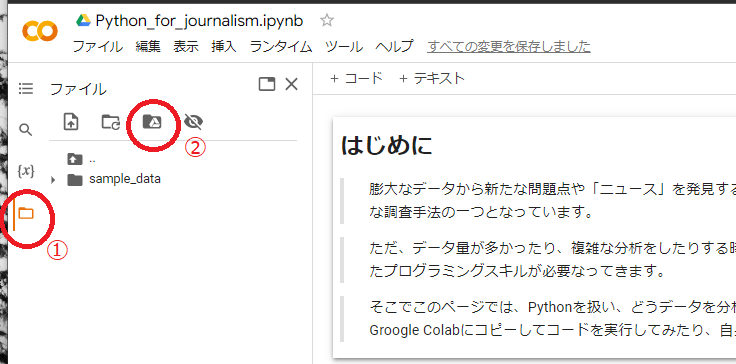

②．「drive」というフォルダーが表示されれば準備完了です。自身のグーグルドライブとこのノードブックが連携されたので、Pythonによるデータ分析が行えるようになります。
※Google Clabで分析する場合は、オープンデータなど機密性が低いデータのみを扱ってください。

初めてGoogle Clabを活用する人には理解しにくいと思いますが、現状、このようなイメージになっています。

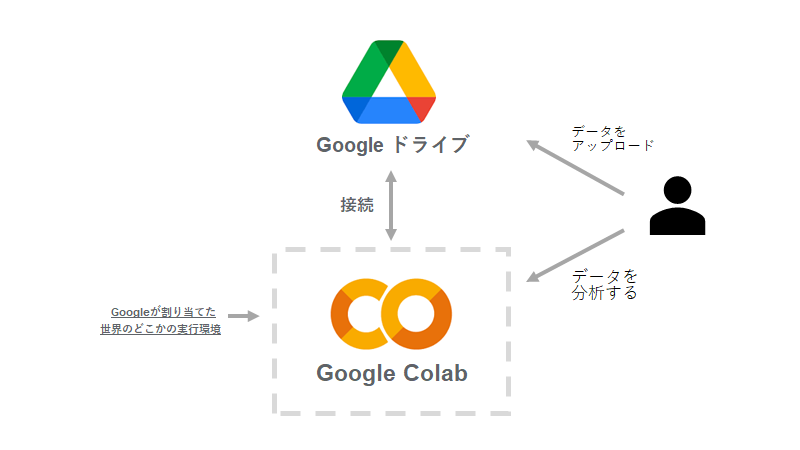

# **事例１．統計データを分析する**

【分析するデータ】
[交通事故統計情報のオープンデータ](https://www.npa.go.jp/publications/statistics/koutsuu/opendata/index_opendata.html)

【アウトプットの目標】
[朝日新聞デジタル：みえない交差点](https://www.asahi.com/special/jiko-kosaten/)

**１－１．ファイルを読み込む**

In [ ]:
#分析するためのライブラリーを読み込む（「エクセルをPCで立ち上げる」イメージ）
import pandas as pd
#ファイルを読み込む（エクセルでファイルを開く、のようなイメージ）
df = pd.read_csv('./drive/MyDrive/traffic_accident_analysis/honhyo_2021_utf.csv') 

In [ ]:
#読み込んだファイルの中身を表示
df

**１－２．データの中身を見てみる**

In [ ]:
#どんな列がある？
df.columns

In [ ]:
#特定の列のユニークな値を確認する
df["発生日時　　年"].value_counts()

In [ ]:
#2021年のデータのみに絞り込む
df = df[df["発生日時　　年"] == 2021]
#データの中身を確認
df.shape

In [ ]:
#月ごとの事故数を確認
df["発生日時　　月"].value_counts()

In [ ]:
#曜日別の事故数を確認
df["曜日(発生年月日)"].value_counts()

In [ ]:
#昼夜別の事故数を確認
df["昼夜"].value_counts()

In [ ]:
#道路の形ごとの事故数を確認
df["道路線形"].value_counts()

**１－２．みえない交差点を探してみる**

In [ ]:
###道幅が狭い交差点に対象を絞る
#11 交差点－小（5.5m未満）－小
#14 交差点－中（5.5m以上）－小
#15 交差点－中（5.5m以上）－中
#17 交差点－大（13.0ｍ以上）－小
#18 交差点－大（13.0ｍ以上）－中
#19 交差点－大（13.0ｍ以上）－大

df = df[(df["車道幅員"] == 11) | (df["車道幅員"] == 14) | (df["車道幅員"] == 15)]

In [ ]:
#都道府県を絞る場合は実行
######各都道府県のコードは以下のとおり##############################################
#10: 北海道（札幌方面）,11: 北海道（函館方面）,
#12: 北海道（旭川方面）,13: 北海道（釧路方面）,
#14: 北海道（北見方面）,20: 青森,21: 岩手,22: 宮城,23: 秋田,24: 山形,
#25: 福島,30: 東京,40: 茨城,41: 栃木,42: 群馬,43: 埼玉,44: 千葉,45: 神奈川,
#46: 新潟,47: 山梨,48: 長野,49: 静岡,50: 富山,51: 石川,52: 福井,53: 岐阜,
#54: 愛知,55: 三重,60: 滋賀,61: 京都,62: 大阪,63: 兵庫,64: 奈良,65: 和歌山,
#70: 鳥取,71: 島根,72: 岡山,73: 広島,74: 山口,80: 徳島,81: 香川,82: 愛媛,
#83: 高知,90: 福岡,91: 佐賀,92: 長崎,93: 熊本,94: 大分,95: 宮崎,96: 鹿児島,97: 沖縄
####################################################################################

#神奈川県の事故に絞って分析する場合
df = df[df["都道府県コード"] == 45]

In [ ]:
#２点間の距離を計算するライブラリー
from geopy.distance import geodesic

In [ ]:
#半径何メートル以内の事故地点を探すか
accident_distance = 10

#同じ交差点での事故データを１つのグループに束ねて保存する
accident_group_arr = []
accident_group =  []

#調査済みの地点を記録して、処理の重複を避ける
accident_all_cases =  []

**みえない交差点の見つけ方：**[出典](https://digital.asahi.com/articles/photo/AS20220408001113.html)

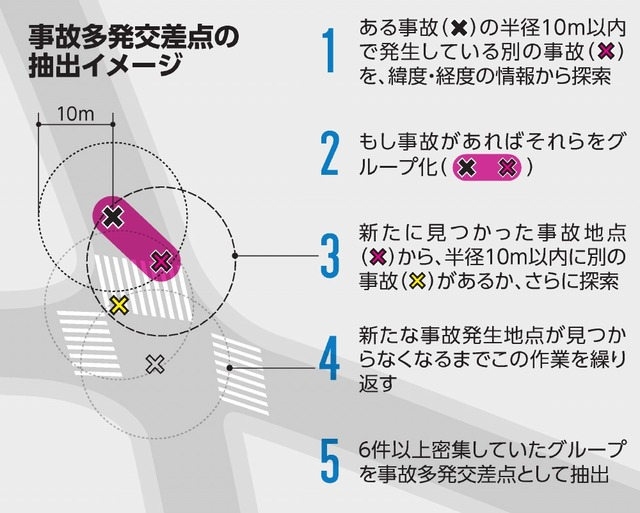

In [ ]:
###############################
###事故多発交差点の探索処理####
###############################

#一行ずつ読み込んで、他に近くの交差点がないか探す
for index, row in df.iterrows():
   #探したことがない地点（「accident_all_cases」に入ってない）なら探索開始
   if not index in accident_all_cases:
      #事故地点登録用と探索の回数変数
      accident_group =  []
      search_count = 1
      #探索する事故地点(中心)の緯度・経度を設定
      Parent_position = (row["north"], row["east"])
      #探す先を同一の警察署管内に絞る
      df_pref = df[(df["都道府県コード"] == row["都道府県コード"]) & (df["警察署等コード"] == row["警察署等コード"])]
      #近い場所での事故が発見出来たかどうかの判定用フラグ
      found_judge_flag = 0
      #事故データが見つからなくなるまで探索し続ける
      while found_judge_flag < 1 :
         #発見できた事故データ数
         found_count = 0
         #１０メートル以内の事故を探す
         #1段階目の探索
         if search_count == 1:
            accident_group_new = []
            for index_2, row_2 in df_pref.iterrows():
               try:
                  Research_position = (row_2["north"], row_2["east"])
                  #２点間の距離を計算
                  dis_tmp = geodesic(Parent_position, Research_position).m
                  #２点間の距離が１０メートル以内（同じ交差点である可能性が高い）の場合、１つのグループに束ねる
                  if accident_distance >= dis_tmp:
                     #データの行数（index）をグループに追加
                     accident_group_new.append(index_2)
                     accident_group.append(index_2)
                     #一度調べた事故データは再び調査しないように記録しておく
                     accident_all_cases.append(index_2)
                     #発見できた事故地点数
                     found_count = found_count + 1
               except:
                  pass
            #１段目と２段目以降で処理が異なるので切り替え
            search_count = search_count + 1
         #２段階目以降の探索
         else:
            accident_group_new_before = accident_group_new
            accident_group_new = []
            #前段で新たに見つかった事故地点の近くにある事故を改めて探す
            for new_index in accident_group_new_before:
               #新たに探索する事故の場所をセット
               Parent_position = (df.loc[new_index]["north"], df.loc[new_index]["east"])
               for index_2, row_2 in df_pref.iterrows():
                  try:
                     Research_position = (row_2["north"], row_2["east"])
                     #２点間の距離を計算
                     dis_tmp = geodesic(Parent_position, Research_position).m
                     #２点間の距離が１０メートル以内（同じ交差点である可能性が高い）の場合、１つのグループに束ねる
                     if (accident_distance >= dis_tmp):
                        #未発見の事故地点なら追加
                        if not index_2 in accident_group:
                           #データの行数（index）をグループに追加
                           accident_group_new.append(index_2)
                           accident_group.append(index_2)
                           accident_all_cases.append(index_2)
                           found_count = found_count + 1
                  except:
                     pass
            search_count = search_count + 1
         #事故地点が近くに無かったら探索を終了させる
         if found_count == 0:
            found_judge_flag = 1

      #見つかった事故数が5件以上だったら多発地点として登録する
      if len(accident_group) >= 5:
         accident_group_arr.append(accident_group)
         print(search_count, len(accident_group), accident_group)

In [ ]:
###############################################
######見つけた事故多発地点から一覧表を作る#####
###############################################

#「みえない交差点」グループ番号
gp_name = 0
#一覧表の列名
cols = df.columns.values.tolist()
#アウトプット用の一覧表
df_result = pd.DataFrame(index=[], columns=cols)
#一つ前の分析で見つけた事故多発交差点の行番号から一覧データを作る
for ac_group in accident_group_arr:
   #グループ番号からグループ名を作る
   group_name = "intersection_" + str(gp_name)
   gp_name = gp_name + 1
   #グループを順に取り出す
   df_result_tmp = df.loc[ac_group]
   #グループ名を格納
   df_result_tmp["intersection_name"] = [group_name] * df_result_tmp.shape[0]
   #グループに登録された事故件数（行数）を数えて格納
   df_result_tmp["accident_count"] = [len(ac_group)] * df_result_tmp.shape[0]
   #一覧の末尾にデータを追加
   df_result = pd.concat([df_result, df_result_tmp])

In [ ]:
#####一覧ファイルをグーグルドライブに出力
df_result.to_csv("./drive/MyDrive/traffic_accident_analysis/intersection_table.csv", index=False)

# **事例２．テキストデータを扱う**

In [ ]:
!wget  "https://drive.google.com/uc?export=download&id=1F-g17E2OfPweROelRgbCuNuuwNOB3GvT" -O police_data_201803.csv

**① タイトルに「詐欺」と含まれるデータを抽出する**

In [ ]:
#タイトルに「詐欺」が絞まれるメールに絞る
df_sagi = df[df['配信表題'].str.contains("詐欺")]
#表示
df_sagi

**② 品詞ごとに単語をカウントする**

**②-1 テキスト分析用ライブラリー「GiNZA」のインストール**

In [ ]:
#分析用のライブラリーをインストールする
#!pip install sudachipy sudachidict_core
!pip install -U ginza https://github.com/megagonlabs/ginza/releases/download/latest/ja_ginza_electra-latest-with-model.tar.gz

※念のため、上部メニューの「ランタイム」＞「ランタイムを再起動」を実行

**②-2 テキストを分かち書きしてみる**

In [ ]:
import spacy
nlp = spacy.load('ja_ginza_electra')
#文章を分かち書きするために解析
doc = nlp('データジャーナリズムは、大規模データを解析し新たな解釈を作り出す調査取材の手法です。')

#分析結果を表示
for sent in doc.sents:
    for token in sent:
        #token.orth_：元の単語, token.lemma_：基本形, token.pos_：品詞（英語）, token.tag_：品詞（日本語）
        print(token.orth_, token.lemma_, token.pos_, token.tag_)
    print('EOS')

**②-3 形容詞を数えあげる**

In [ ]:
import spacy

#テキストを分かち書きして、品詞ごとに分類する関数
def TextToWakati_ginza(text, nlp):
   Arr_ADJ = []
   Arr_VERB = []
   Arr_NOUN = []
   Arr_ADV = []
   Arr_PROPN = []
   try:
      doc = nlp(text)
      # 品詞ごとに基本形を抽出する
      for sent in doc.sents:
         #形容詞（ADJ）、動詞（VERB）、名詞（NOUN）、副詞（ADV）、固有名詞（PROPN）を対象に設定
         for token in sent:
            if token.pos_ == "ADJ":
               Arr_ADJ.append(token.lemma_)
            elif token.pos_ == "VERB":
               Arr_VERB.append(token.lemma_)
            elif token.pos_ == "NOUN":
               Arr_NOUN.append(token.lemma_)
            elif token.pos_ == "ADV":
               Arr_ADV.append(token.lemma_)
            elif token.pos_ == "PROPN":
               Arr_PROPN.append(token.lemma_)
   #エラーした場合のスキップ処理
   except:
      print("==エラー==")
      print(text)
   return Arr_ADJ, Arr_VERB, Arr_NOUN, Arr_ADV, Arr_PROPN

#解析の準備
nlp = spacy.load('ja_ginza_electra')
Arr_ADJ_all = []
Arr_VERB_all = []
Arr_NOUN_all = []
Arr_ADV_all = []
Arr_PROPN_all = []

#データの読み込み→解析
for t in df_sagi["配信本文"]:
  Arr_ADJ, Arr_VERB, Arr_NOUN, Arr_ADV, Arr_PROPN = TextToWakati_ginza(t, nlp)
  #出力結果を追加していく
  Arr_ADJ_all = Arr_ADJ_all + Arr_ADJ
  Arr_VERB_all = Arr_VERB_all + Arr_VERB
  Arr_NOUN_all = Arr_NOUN_all + Arr_NOUN
  Arr_ADV_all = Arr_ADV_all + Arr_ADV
  Arr_PROPN_all = Arr_PROPN_all + Arr_PROPN

In [ ]:
#多く含まれる形容詞ランキング（トップ１０）を表示
import collections
#「Arr_ADJ_all」を上記の「Arr_VERB」や「Arr_NOUN」に変えると名詞や動詞のランキングになる
c = collections.Counter(Arr_ADJ_all)
c.most_common(10)

**４－１． ワードクラウドを作成する**

In [ ]:
#フォントファイルを準備する
!apt-get -y install fonts-ipafont-gothic

In [ ]:
import pandas as pd
import spacy
from wordcloud import WordCloud
import random

#テキストを分かち書きして、分析する単語のみを集める関数
def TextToWakati(text, nlp):
   res_arr = []
   try:
      doc = nlp(text)
      for sent in doc.sents:
         for token in sent:
            #形容詞（ADJ）、動詞（VERB）、名詞（NOUN）、副詞（ADV）、固有名詞（PROPN）を対象に設定
            if (token.pos_ == "ADJ") or (token.pos_ == "VERB") or (token.pos_ == "NOUN") or (token.pos_ == "ADV") or (token.pos_ == "PROPN"):
               if not token.is_stop:
                  res_arr.append(token.lemma_)
   except:
      print(text)
   return res_arr

#分析ファイルの読み込み★１
df = pd.read_csv('police_data_201803.csv')
#詐欺に関するメールに対象を絞る★２
df = df[df['配信表題'].str.contains("詐欺")]
#それぞれのテキストを分かち書きしていく
nlp = spacy.load('ja_ginza_electra')
res_arr_all = []
#対象は「配信本文」という列★３
for t in df["配信本文"]:
   wt = TextToWakati(t, nlp)
   res_arr_all = res_arr_all + wt

random.shuffle(res_arr_all)
word_text = " ".join(res_arr_all)

#ワードクラウドを作成する
fpath = "/usr/share/fonts/truetype/fonts-japanese-gothic.ttf"
wordcloud = WordCloud(background_color="white", colormap="summer", font_path=fpath,collocations = False, width=600,height=400,min_font_size=12, prefer_horizontal=1)
wordcloud.generate(word_text)
#画像を保存 
wordcloud.to_file("./wordcloud.png")

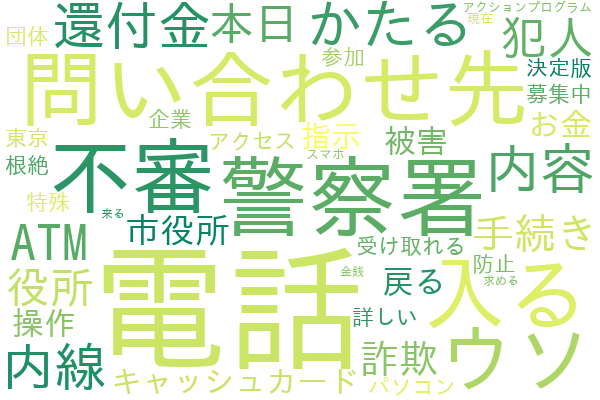

In [ ]:
#完成した画像を表示する
from IPython.display import Image,display_png
display_png(Image('wordcloud.png'))

別の分析データをダウンロード

In [ ]:
#テスト用のファイルをダウンロード
!wget  "https://drive.google.com/uc?export=download&id=102FWqIj4ngBtI9QcnNijhmKpHWSfyKWQ" -O police_data_201903.csv

再度、ワードクラウドを作成

In [ ]:
import pandas as pd
import spacy
from wordcloud import WordCloud
import random

#テキストを分かち書きして、分析する単語のみを集める関数
def TextToWakati(text, nlp):
   res_arr = []
   try:
      doc = nlp(text)
      for sent in doc.sents:
         for token in sent:
            #形容詞（ADJ）、動詞（VERB）、名詞（NOUN）、副詞（ADV）、固有名詞（PROPN）を対象に設定
            if (token.pos_ == "ADJ") or (token.pos_ == "VERB") or (token.pos_ == "NOUN") or (token.pos_ == "ADV") or (token.pos_ == "PROPN"):
               if not token.is_stop:
                  res_arr.append(token.lemma_)
   except:
      print(text)
   return res_arr

#分析ファイルの読み込み★１
df = pd.read_csv('police_data_201903.csv')
#詐欺に関するメールに対象を絞る★２
df = df[df['配信表題'].str.contains("詐欺")]
#それぞれのテキストを分かち書きしていく
nlp = spacy.load('ja_ginza_electra')
res_arr_all = []
#対象は「配信本文」という列★３
for t in df["配信本文"]:
   wt = TextToWakati(t, nlp)
   res_arr_all = res_arr_all + wt

random.shuffle(res_arr_all)
word_text = " ".join(res_arr_all)

#ワードクラウドを作成する
fpath = "/usr/share/fonts/truetype/fonts-japanese-gothic.ttf"
wordcloud = WordCloud(background_color="white", colormap="summer", font_path=fpath,collocations = False, width=600,height=400,min_font_size=12, prefer_horizontal=1)
wordcloud.generate(word_text)
#画像を保存 
wordcloud.to_file("./wordcloud.png")

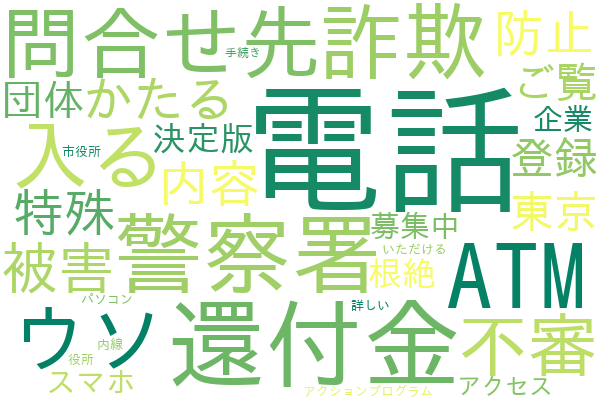

In [ ]:
#完成した画像を表示する
from IPython.display import Image,display_png
display_png(Image('wordcloud.png'))